
# Perform cross-validation on one simulated dataset
## Lotka-Volterra

In [54]:
from scipy import integrate
import numpy as np

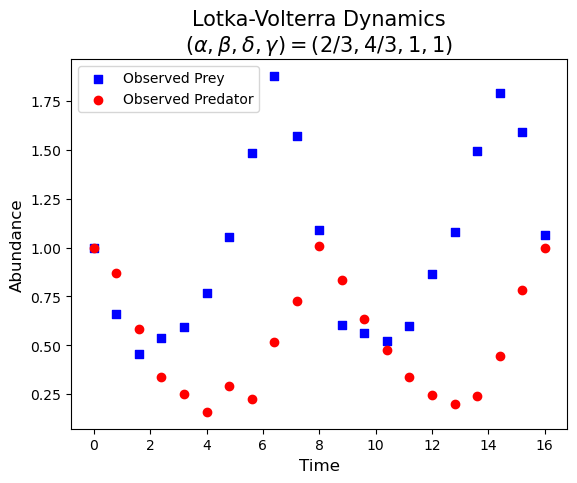

In [55]:
import matplotlib.pyplot as plt
Nt = 21
tmax = 16
tspan = np.linspace(0.,tmax, Nt)
X = np.load("data/lotka_volterra/lv_CV.npy")

X0 = [1,1]
X_new = X

plt.scatter(tspan, X_new[:,0], label = "Observed Prey", c = "b", marker = "s")
plt.scatter(tspan, X_new[:,1], label = "Observed Predator", c = "r")
plt.xlabel("Time", size = 12)
plt.ylabel("Abundance", size = 12)
plt.title("Lotka-Volterra Dynamics\n$(\\alpha,\\beta,\delta,\gamma) = (2/3,4/3,1,1)$", size = 15)
plt.legend()

In [56]:
def return_train_test_folds(k, max_t):
    test = []
    train = []
    for i in range(k):
        test_idxs = list(range(int( 1+ (max_t/k)*i ), np.min([int(1+(max_t/k)*(i+1)), max_t])))
        train_idxs = list(np.setdiff1d(np.array(range(max_t)), np.array(test_idxs)))
        test.append(test_idxs)
        train.append(train_idxs)
    return train, test

In [57]:
train, test = return_train_test_folds(5,21)

In [ ]:
import pysindy as ps

def MSE(x,y):
    return np.mean((x-y)**2)

poly_order = 2
mses = []
thresholds = [0.16,0.17, 0.18,0.19,0.20,0.25]
lambdas = [0.0075,0.01, 0.02, 0.03,0.15, 1]
best_val_mse = np.inf 
cv_values = None
best_model= None
for l in lambdas:
    for t in thresholds:
        print(l,t)
        mse_across_k = []
        for k in range(len(train)):
            # train val split 
            X_train = X_new[train[k], :]; tspan_train = tspan[train[k]]
            X_val = X_new[test[k],:]; tspan_val = tspan[test[k]]

            # fit on training data
            model = ps.SINDy(ps.STLSQ( threshold = t, alpha = l), 
                            feature_library=ps.PolynomialLibrary(degree=poly_order))
            model.fit(X_train, t=tspan_train)

            # test on validation data
            preds = model.simulate(X0, t=tspan, integrator="odeint")
            mse_k = MSE(preds[test[k],:], X_val)
            mse_across_k.append(mse_k)


        mse = np.nanmean(mse_across_k)
        mses.append(mse)
        print(mse)

        # store the information of the best model seen    
        if mse <= best_val_mse:
            best_val_mse = mse
            cv_values = (l,t)
            model = ps.SINDy(ps.STLSQ( threshold = t, alpha = l),
                feature_library=ps.PolynomialLibrary(degree=poly_order))
            model.fit(X_new, t=tspan)
            best_model = model
        


In [ ]:
# values chosen by cross-validation
cv_values

In [58]:
poly_order = 2
best_model = ps.SINDy(ps.STLSQ( threshold = 0.18, alpha = 0.01), 
                            feature_library=ps.PolynomialLibrary(degree=poly_order))
best_model.fit(X_new, t=tspan)


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x0', 'x1'],
      optimizer=STLSQ(alpha=0.01, threshold=0.18))

In [59]:
best_model.print()

(x0)' = 0.636 x0 + -1.255 x0 x1
(x1)' = -0.839 x1 + 0.833 x0 x1


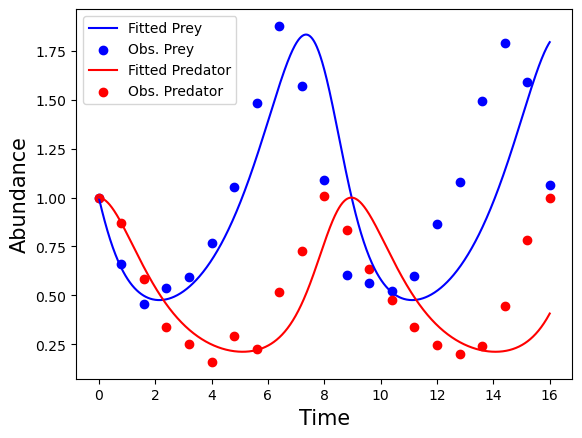

In [60]:
solns = best_model.simulate(X0, np.linspace(0.,tmax,1000))
plt.plot( np.linspace(0.,tmax,1000),solns[:,0], label = "Fitted Prey", c = "b")
plt.scatter(tspan, X_new[:,0], label = "Obs. Prey", c = 'blue')
plt.plot( np.linspace(0.,tmax,1000),solns[:,1], label = "Fitted Predator", c = "r")
plt.scatter(tspan, X_new[:,1], label = "Obs. Predator", c ='red')
plt.xlabel("Time", size = 15)
plt.ylabel("Abundance", size = 15)
plt.legend()
plt.savefig("figures/lv_cv_solutions.png", dpi = 300, bbox_inches = "tight")


# Regression

In [61]:
import numpy as np
import matplotlib.pyplot as plt
# number of covariates
d = 20

# number of important covariates 
important= 2 

rho = 0.99

C = np.eye(d)
C[0,1] = rho; C[1,0] = rho
C[2,3] = rho; C[3,2] = rho
C[3,4] = rho; C[4,3] = rho
C[2,4] = rho; C[4,2] = rho


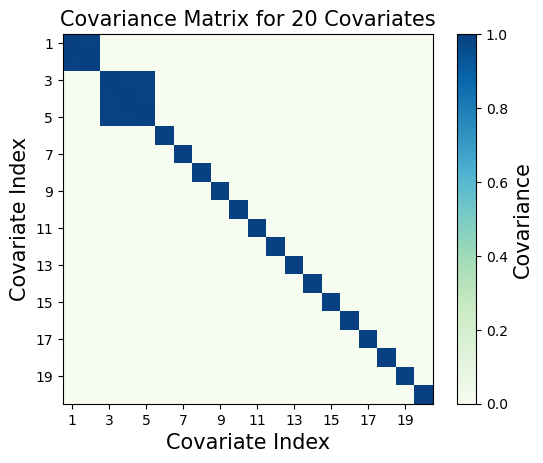

In [62]:
fig, ax = plt.subplots()
im = ax.imshow(C, cmap = "GnBu", vmin = 0, vmax= 1)
cbar = fig.colorbar(im)
cbar.set_label("Covariance", size = 15)
ticks = np.arange(0,20,2)
tick_labels = ["{}".format(i)for i in np.arange(1,21,2)]
plt.xticks(ticks, tick_labels) 
plt.yticks(ticks, tick_labels)
plt.title("Covariance Matrix for 20 Covariates", size = 15)
plt.xlabel("Covariate Index", size = 15)
plt.ylabel("Covariate Index", size = 15)
plt.savefig("figures/regression_cov_matrix.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [63]:
import numpy as np
Xy = np.load("data/regression_rho0.99/reg_CV.npy")
X = Xy[:,:-1]; y = Xy[:,-1]

In [64]:
from sklearn.linear_model import LassoCV, Lasso

cv_model = LassoCV(cv=5, random_state=0, alphas = np.linspace(0.001,1,100), max_iter=10000).fit(X,y)

In [65]:
# chosen lambda value
cv_model.alpha_

0.112

Text(0.5, 1.0, 'Regression 5 Fold Validation MSE')

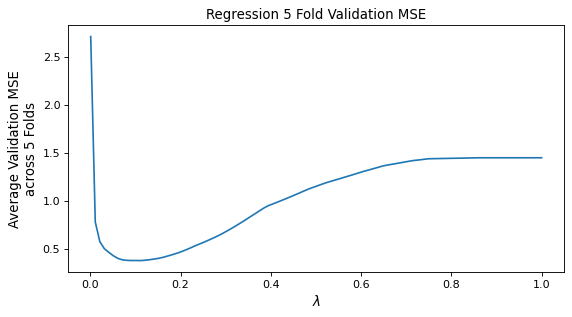

In [66]:
from matplotlib.pyplot import figure

figure(figsize=(8,4), dpi=80)

plt.plot(cv_model.alphas_, cv_model.mse_path_.mean(1))
plt.xlabel("$\\lambda$",size = 12)
plt.ylabel("Average Validation MSE\nacross 5 Folds", size = 12)
plt.title("Regression 5 Fold Validation MSE")


In [67]:
# regression coefficients when lambda = 0.112
cv_model.coef_

array([ 0.61618446,  0.        ,  0.        ,  0.        ,  0.76364293,
        0.19125879,  0.01347643, -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ])

In [68]:
# regression coefficients when lambda = 0.5
model = Lasso(alpha= 0.5)
model.fit(X,y)

model.coef_

array([ 0.06727165,  0.        ,  0.        ,  0.05949196,  0.20247385,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.        ])